# Assignment 7

Name 1: Sharmila Upadhyaya  <br/>
Student id 1: 7008858 <br/>
Email 1: shup00001@stud.uni-saarland.de <br/>


Name 2: Isidora Jeknic <br/>
Student id 2: 7008924 <br/>
Email 2: isje00001@stud.uni-saarland.de <br/> 

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the Python files for exercises 1 and 2. There is no need to submit the data files. <br/>
Upload the zipped folder in Teams. Make sure to click on "Turn-in" after your upload your submission, otherwise the assignment will not be considered as submitted. Only one from the group should make the submisssion.

---

## Exercise 1: Count-Trees (5 points)

Your task is to implement a count-tree with variable maximum history. It is a memory-efficient way to store n-gram counts which can also be used to create an intuitive back-off after the tree is pruned.

The tree object should support the following four operations:
- Increment a count of a specific n-gram (even if not present)
- Retrieve counts given the history (variable length)
- Retrieve the conditional probability of a word given the history. (Proportion count between branches)
- Pruning all nodes with counts less or equal to $k$

**1.1 (2 points)**

Make sure your implementation is correct by passing the asserts in the first code cell.

**1.2 (1 point)**

The next cell will incrementally add a quad-gram to the tree. Plot the perplexity of trigram language model (induced by this count tree) against the number of added n-grams. Comment on the curve shape. Smooth this language model with a zerogram distribution using a linear combination ($0.75\times p_4 + 0.25\times p_0$).

**1.3 (1 point)**

For the given range of thresholds, prune your tree and see how the threshold affects the performance. Plot the results (perplexity vs. threshold).

**1.4 (1 point)**

1. If you first prune with threshold $k_1$ and get tree $t_1$, then prune with $k_2$ and get $t_2$ what will be the relationship between $t_1$ and $t_2$ if $k_1 \ge k_2$? (0.25 points)
2. What is the memory benefit of count trees, in comparison to storing the counts as a dictionary `{n-gram:freq}`? (0.25 points)
3. If we pruned the tree so that only the first level is preserved, what distribution could we model with this tree? (0.25 points)
4. Pruning the count tree is said to be a dynamic way of smoothing the language model. Elaborate on how this smoothing happens. (0.25 points)

In [1]:
from importlib import reload
import exercise_1
exercise_1 = reload(exercise_1)

tree = exercise_1.CountTree(n=4)

assert tree.get("") == 0
tree.add("ABCE")
tree.add("ABCD")
tree.add("ABCD")
tree.add("QBCD")
tree.add("QQCD")
tree.add("BCDA")
tree.add("1234")
tree.add("1234")
tree.add("1234")
tree.add("1234")
tree.add("1234")
tree.add("5634")
assert tree.get("ABCD") == 2
assert tree.get("ABCX") == 0
assert tree.get("BCD") == 3
assert tree.get("D") == 4
assert tree.get("CD") == 4
assert tree.get("1234") == 5
assert tree.get("5634") == 1
tree.prune(4)
assert tree.get("ABCD") == 4
assert tree.get("XXCD") == 4
assert tree.get("D") == 4
assert tree.get("1234") == 5
assert tree.get("5634") == 1

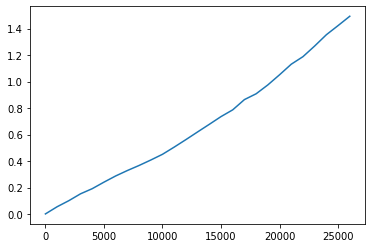

In [4]:
import matplotlib.pyplot as plt

 

plot_x = []
plot_y = []

 

ngrams = []
tree = exercise_1.CountTree(n=4)
with open("data/alice_in_wonderland.txt", "r") as f:
  tokens = f.read().lower().split()
  for i in range(len(tokens)-4):
    ngrams.append(tuple(tokens[i:i+4]))

 

vocab = set(tokens)
for i,ngram in enumerate(ngrams):
  tree.add(ngram)
  if i % 1000 == 0:
    plot_x.append(i)
    plot_y.append(tree.perplexity(ngrams, vocab))

 

plt.plot(plot_x, plot_y)

[1, 2, 3, 4, 5, 10, 25, 50, 75, 100]
[1.53345497548798, 1.4682240091559002, 1.4339499547876207, 1.408896146965079, 1.3990234201854972, 1.3671131818485824, 1.3500465298493947, 1.345035509012332, 1.3442579571729447, 1.3442579571729447]


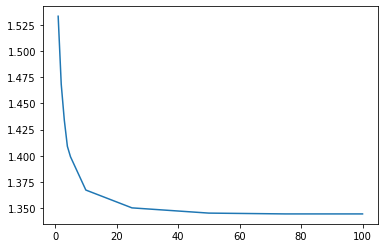

In [5]:
plot_x = []
plot_y = []

for threshold in [1,2,3,4,5,10,25,50,75,100]:
  tree.prune(threshold)
  plot_x.append(threshold)
  plot_y.append(tree.perplexity(ngrams, vocab))

print(plot_x)
print(plot_y)

plt.plot(plot_x, plot_y)

# Answer 1.4 #

1.4.1: $t_1$ and $t_2$ tree would be same since we prune first with $k_1$ and it is greater or equal to $k_2$, pruning with $k_2$ would make no change in the tree $t_1$

1.4.2 It is both memory efficient and computationally cheap as in normal dictionary count, as done in previous exercise, histories are not saved together and have no direct association with there preceding element which makes it difficult to get history count through single data structure , rather we use multiple dictionaries.

1.4.3 It will be an unigram distribution and will not be conditioned on histories.

1.4.4 Pruning in the above exercise is smoothing in the sense that by filtering subtree with count less than equal to threshold, we are not removing those subtree. Instead we are using backing off approach by preserving the value of parent of the subtree and removing the childrens. Hence, if a ngram pair is not in the corpus, we still get the count of one element.

## Exercise 2: Kneser-Ney Smoothing (5 points)

This exercise aims to provide a basic understanding of Kneser-Ney Smoothing. Kneser-Ney Smoothing makes use of *continuation counts* of words for lower order n-grams, given as

\begin{equation}
C_{KN} = 
\begin{cases}
\text{count}(\bullet) & \text{for highest order} \\
\text{continuationcount}(\bullet) & \text{for lower orders}
\end{cases}
\end{equation}


For a trigram distribution, Kneser-Ney Smoothing is implemented using the following equations:

$$P_{KN}(w_3|w_1, w_2) = \frac{\max\{N(w_1 w_2 w_3)-d,0\}}{N(w_1 w_2)} + \lambda(w_1, w_2)P_{KN}(w_3|w_2)$$

$$P_{KN}(w_3|w_2) = \frac{\max\{N_{+}(\bullet w_2 w_3)-d,0\}}{N_{+}(\bullet w_2 \bullet)} + \lambda(w_2)P_{KN}(w_3)$$

\begin{equation}
P_{KN}(w_3) = \begin{cases}
\frac{N_{+}(\bullet w_3)}{N_{+}(\bullet \bullet)} & \text{if $w_3 \in$ V} \\
\frac{1}{V} & \text{otherwise}
\end{cases}
\end{equation}

$\lambda$ is used to normalise the discounted probability mass and is given by

$$\lambda(w_1, w_2) = \frac{d}{N(w_1 w_2)} \cdot N_{+}(w_1 w_2 \bullet)$$

$$\lambda(w_2) = \frac{d}{N(w_2)} \cdot N_{+}(w_2 \bullet)$$

**2.1 (4.5 points)**

* Your first task is to understand what these terms represent and fill it in the table below (4-5 words each).

* Create a trigram-level model on the given text, `alice_in_wonderland.txt`. Write your implementation in the file `exercise_2.py`. Preprocess the text by punctuation removal, lowercasing, and tokenisation. There is no need to split the data into train and test sets. (0.5 points)

In [4]:
from importlib import reload
import exercise_2
exercise_2 = reload(exercise_2)

file = open("data/alice_in_wonderland.txt", "r")
text = file.read()

# TODO: Preprocess text
tokens = exercise_2.preprocess(text)

* 
Write a simple class `KneserNey` in `exercise_2` that calculates the different parameters required for finding the trigram conditional probability. You may modify the function signature and add other functionality as required. <br/>
Now, consider the trigrams `"alice said nothing"` and `"alice said nichts"`. For these trigrams, estimate the values mentioned in the table given below and fill in the obtained results. The discounting parameter *d* = 0.75. (3 points)

In [5]:
KN_model = exercise_2.KneserNey(tokens, d=0.75, N=3)

t1 = "alice said nothing"
t2 = "alice said nichts"

# TODO
# Get the required parameters
KN_model.get_params(t1)
KN_model.get_params(t2)

|V| = 2574
N+(**) = 14520
N(w1w2w3) =  2
N(w1w2) =  11
N(w1w2*) = {('alice', 'said'): 6, ('said', 'nothing'): 5}
N(w2*) - unigrams = {'said': 54, 'nothing': 21, 'alice': 143}
N(*w2w3) = {('alice', 'said'): 11, ('said', 'nothing'): 5}
N(*w3) = {'said': 213, 'nothing': 22, 'alice': 150}
N(*w2*) = {'said': 462, 'nothing': 34, 'alice': 398}
lambda - bigrams: {('alice', 'said'): 0.40909090909090906, ('said', 'nothing'): 0.625}
lambda - unigrams: {'said': 0.08766233766233766, 'nothing': 0.4632352941176471, 'alice': 0.268796992481203}

|V| = 2574
N+(**) = 14520
N(w1w2w3) =  0
N(w1w2) =  11
N(w1w2*) = {('alice', 'said'): 6, ('said', 'nichts'): 0}
N(w2*) - unigrams = {'said': 54, 'nichts': 0, 'alice': 143}
N(*w2w3) = {('alice', 'said'): 11, ('said', 'nichts'): 0}
N(*w3) = {'said': 213, 'nichts': 0, 'alice': 150}
N(*w2*) = {'said': 462, 'nichts': 0, 'alice': 398}
lambda - bigrams: {('alice', 'said'): 0.40909090909090906, ('said', 'nichts'): 0}
lambda - unigrams: {'said': 0.08766233766233766, 'ni

| Term in Kneser-Ney |   Value t1  | Value t2 | Description | 
|---|---|---| --- |
|$N(w_1w_2w_3)$| 2 | 0 |Count of trigram|
|$N(w_1 w_2)$| 11 | 11 |Count of bigram|
|$N_{+}( \bullet w_2 w_3)$| 5  | 0 | Number of unique trigrams ending with $(w_2, w_3)$|
|$N_{+}( \bullet w_2 \bullet)$| 462 | 462 | Number of unique trigrams with $w_2$ in the second position|
|$N_{+}( \bullet w_3)$| 22 | 0 | Number of unique bigrams ending with $w_3$|
|$N_{+}( \bullet \bullet)$| 14520 | 14520 | Number of unique bigrams |
|$N_{+}(w_1 w_2 \bullet)$| 6 |6 |Number of words that follow the bigram $(w_1, w_2)$ |
|$N_{+}(w_2 \bullet)$| 54 | 54 |Number of unique words that follow $w_2$ in a bigram|
|$\lambda(w_1 w_2)$| 0.40909090909090906 | 0.40909090909090906 |Normalized constant; probability mass that's been discounted (bigram)|
|$\lambda(w_2)$| 0.08766233766233766 | 0.08766233766233766 |Normalized constant; probability mass that's been discounted (unigram)|

* Using the values obtained above, manually calculate $P_{KN}(w_3)$, $P_{KN}(w_3|w_2)$, and $P_{KN}(w_3|w_1, w_2)$ for the given trigrams. (1 point)

| $P_{Kneser-Ney}$  | $t_1$ ("alice said nothing")  | $t_2$ ("alice said nicht") |  
|-------|-------| --- |
| $P_{KN}(w_3)$     | 0.00152 | 0.00039 |  
|$P_{KN}(w_3|w_2)$ | 0.0093 | 3.40569e-05 |  
|$P_{KN}(w_3|w_1, w_2)$ | 0.11745 | 1.393235e-05|


$t_1$:  
$ P_{KN}(w_3) = \frac{22}{14520} = 0.0015151515151515152$
$ P_{KN}(w_3|w_2) = \frac{max(5-0.75, 0)}{462} + 0.08766233766233766 \times 0.0015151515151515152 = 0.009331955922865015$
$P_{KN}(w_3|w_1, w_2) = \frac{max(2-0.75, 0)}{11} + 0.40909090909090906\times0.009331955922865015 = 0.11745398196844478$  <br><br>


$t_2$:  
$ P_{KN}(w_3) = \frac{1}{2574} = 0.0003885003885003885$  
$ P_{KN}(w_3|w_2) = \frac{max(0-0.75,0}{462} + 0.08766233766233766 \times 0.0003885003885003885 = 3.405685223867042e-05 $  
$P_{KN}(w_3|w_1, w_2) = \frac{max(0-0.75,0}{11} + 0.40909090909090906 \times 3.405685223867042e-05 = 1.3932348643092445e-05 $



**2.2 (0.5 points)**

Take a look at this [video](https://www.youtube.com/watch?v=cbAxvpBFyNU) on Kneser-Ney smoothing by Dan Jurafksy. Make sure to undestand his *San Francisco* example. <br/>
How will Kneser-Ney Smoothing handle the following bigrams (answer in 3-4 sentences)? 

* Abu Dhabi

* Game Over


### **Answer - 2.2**

The results depend on the training corpus; if we assume that both $w_2$'s of these bigrams appear very frequently (like the *San Francisco* example), Kneser-Ney would mark *Dhabi* similarly to *Francisco*, as it only appears after *Abu*; on the other hand, *over* most likely appears in many different contexts (again, depending on the text), which Kneser-Ney would account for and adjust the probabilities accordingly. Lower unigram continuation P would be assigned to the former (*Dhabi*) than the latter (*over*).

## Bonus (2 points)

For each of the smoothing techniques below,

1. Laplace/add-1 smoothing (0.3 points)
2. Add-$\alpha$ smoothing (0.3 points)
3. Linear interpolation (0.3 points)
4. Absolute discounting (0.3 points)
5. Good-Turing (0.3 points)
6. Kneser-Ney smoothing (0.3 point)

* Give the intuition behind it
* State at least one drawback and
* Explain how the ensuing smoothing technique accounts for this drawback.

You can do so in continuous text or in bullet points. Write 3-5 sentences for each technique. For Kneser-Ney smoothing, you should suggest *and explain* an improved version from the literature, e.g. [here](http://nrs.harvard.edu/urn-3:HUL.InstRepos:25104739) (this tutorial may also be helpful for the rest of the exercise).

Please note that while the points for this bonus exercise are the immediate motivation, your self-made comparison will be highly beneficial for the exam.

1. Laplace/add-1
- Intuition: pretend to have seen all words one more time to avoid the zeros impacting the probability calculations.
- Con: very blunt, makes massive changes in the reconstituted counts to account for the redistributed probability mass; not representative
- Solution: use interpolation; additionally, use used only for specific tasks (text classification) where this won't be too much of an issue) 

2. Add-$\alpha$:  
- Intuition: pretend to have seen all words $\alpha$ more times, to avoid the zeros. (version of Laplace, i.e. Laplace is the add-$\alpha$ for $\alpha = 1$)
- Con: ignores frequency of histories; not representative
- Solution: use linear interpolation

3. Linear Interpolation:
- Intuition: if an n-gram has been seen only a few times, it helps to use a mixture of lower-order n-grams.
- Con: it's not always necessary to use all lower-order n-grams (if the highest-order n-gram is reliable) - waste of resources 
- Solution: 

4. Absolute Discounting:
- Intuition: redistribute a fixed amount of probability mass to OOV tokens by subtracting a fixed amount from each count
- Con: the unigram probability isn't a good estimator (the *San Francisco* example - a word may be frequent but occur only in a single context)
- Solution: use a continuation probability (Kneser-Ney smoothing)

5. Good-Turing:
- Intuition: unseen words are as likely to appear in a text as words that were seen only once - use words seen once to approximate the counts for unseen words.
- Con: If $k$ is large enough, the technique results in a lot of 0's, which messes with the distribution
- Solution: Set a threshold above which frequencies remain the same or use the Simple GT smoothing variant
6. Kneser-Ney
- Intuition: simply counting occurances is too naive; some words tend to occur together frequency; instead of counting the # of occurrances (unigram), count the context instead
- Con: the discount parameter is static and will not result in the optimal result for all count values.
- Solution: apply a modified KN - instead of a fixed discounting parameter, apply a different one depending on the count (if the count is 0, 1, 2 or 3+), since the ideal discounting parameter will be different for OOV tokens, tokens that have appeared only once, twice, or three or more times.